## Connect to Google-Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks/Effectiveness of STD Drugs/Dataset"

STD_Drugs_Effectiveness_dataset.npz  test.csv  train.csv


## Import Packages

In [3]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

Cloning into 'LightGBM'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 17509 (delta 0), reused 0 (delta 0), pack-reused 17505
Receiving objects: 100% (17509/17509), 11.91 MiB | 27.42 MiB/s, done.
Resolving deltas: 100% (12770/12770), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 28.19 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'
/content/LightGBM
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr

In [4]:
%pip install emoji
%pip install -U spacy
!python -m spacy download en

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=a924012f8c45fd5a99480b0038b91cef9a5ca952776da77b26f5515955316247
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.2.4)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [5]:
import sys
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import emoji

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import tensorflow_hub as hub
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Set file paths for training and prediction datasets

In [0]:
train_dataset = "/content/drive/My Drive/Colab Notebooks/Effectiveness of STD Drugs/Dataset/train.csv"
predict_dataset = "/content/drive/My Drive/Colab Notebooks/Effectiveness of STD Drugs/Dataset/test.csv"

## Exploratory Data Analysis

In [0]:
# Read train dataset
train_df = pd.read_csv(train_dataset)
train_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,8.022969
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,7.858458
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,6.341969
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,6.590176
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,6.144782


In [0]:
# Read predict dataset
predict_df = pd.read_csv(predict_dataset)
predict_df.head()

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
0,163740,Mirtazapine,"""I&#039;ve tried a few antidepressants over th...",28-Feb-12,22,Depression,10
1,39293,Contrave,"""Contrave combines drugs that were used for al...",5-Mar-17,35,Weight Loss,9
2,208087,Zyclara,"""4 days in on first 2 weeks. Using on arms an...",3-Jul-14,13,Keratosis,4
3,23295,Methadone,"""Ive been on Methadone for over ten years and ...",18-Oct-16,21,Opiate Withdrawal,7
4,97013,Ambien,"""Ditto on rebound sleepless when discontinued....",13-Jan-15,44,Insomnia,2


In [0]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32165 entries, 0 to 32164
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   patient_id                  32165 non-null  int64  
 1   name_of_drug                32165 non-null  object 
 2   use_case_for_drug           32165 non-null  object 
 3   review_by_patient           32165 non-null  object 
 4   effectiveness_rating        32165 non-null  int64  
 5   drug_approved_by_UIC        32165 non-null  object 
 6   number_of_times_prescribed  32165 non-null  int64  
 7   base_score                  32165 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.0+ MB


In [0]:
predict_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10760 entries, 0 to 10759
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   patient_id                  10760 non-null  int64 
 1   name_of_drug                10760 non-null  object
 2   review_by_patient           10760 non-null  object
 3   drug_approved_by_UIC        10760 non-null  object
 4   number_of_times_prescribed  10760 non-null  int64 
 5   use_case_for_drug           10760 non-null  object
 6   effectiveness_rating        10760 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 588.6+ KB


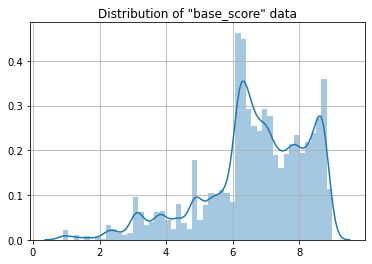

In [0]:
# Plot distribution of data in "base_score" field
ax = sns.distplot(train_df['base_score'].values).set_title('Distribution of "base_score" data')
plt.grid()

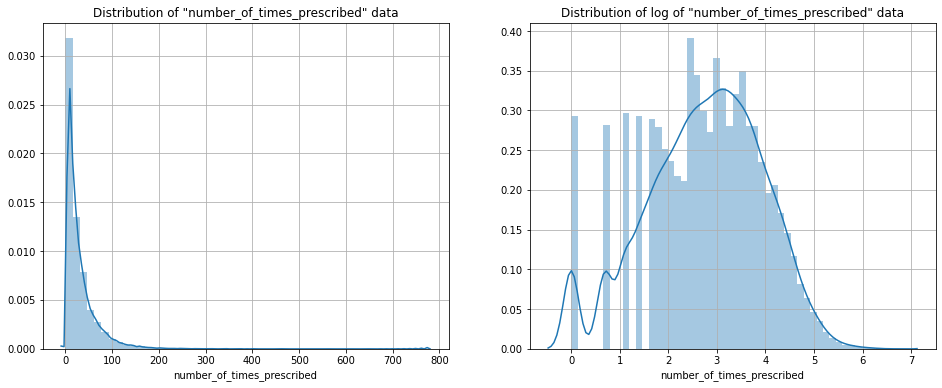

In [0]:
# Plot distribution of data in "number_of_times_prescribed" field
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.distplot(train_df['number_of_times_prescribed']).set_title('Distribution of "number_of_times_prescribed" data')
plt.grid()
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train_df['number_of_times_prescribed'])).set_title('Distribution of log of "number_of_times_prescribed" data')
plt.grid()

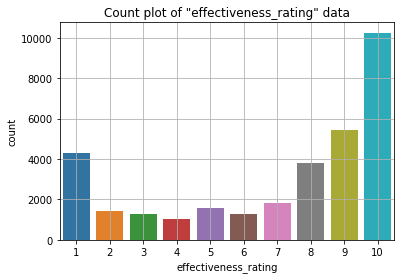

In [0]:
# Plot count of data in "effectiveness_rating" field
sns.countplot(x="effectiveness_rating", data=train_df).set_title('Count plot of "effectiveness_rating" data')
plt.grid()

## Helper functions to process text data

In [0]:
def char_is_emoji(character):
    # Description: Function to check if input character is an emoji
    return character in emoji.UNICODE_EMOJI

In [0]:
def text_has_emoji(text):
    # Description: Function to check if input text contains an emoji
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

In [0]:
def deEmojify(inputString):
    # Description: Function to remove the emojis in input string
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [0]:
def remove_punctuations(text):
    # Description: Function to remove any punctuations in input text
    punct =[]
    punct += list(string.punctuation)
    punct += '’'
    punct += '-'
    punct.remove("'")
    
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

In [0]:
def nlp(df, field_name):
    # Description: Function to perform basic text pre-processing
  
    # lowercase everything
    df['token'] = df[field_name].apply(lambda x: x.lower())
    
    # get rid of '\n' from whitespace 
    df['token'] = df['token'].apply(lambda x: x.replace('\n', ' '))
    
    # regex remove hyperlinks
    df['token'] = df['token'].str.replace('http\S+|www.\S+', '', case=False)
    
    # removing '&gt;'
    df['token'] = df['token'].apply(lambda x: x.replace('&gt;', ''))
    
    # Checking if emoji in tokens column
    #df['emoji'] = df['token'].apply(lambda x: text_has_emoji(x))
    
    # Removing Emojis from tokens
    df['token'] = df['token'].apply(lambda x: deEmojify(x))
    
    # remove punctuations
    df['token'] = df['token'].apply(remove_punctuations)
    
    # remove ' s ' that was created after removing punctuations
    df['token'] = df['token'].apply(lambda x: str(x).replace(" s ", " "))
    
    return df

In [0]:
sp = spacy.load('en_core_web_sm')
lookups = Lookups()
lemm = Lemmatizer(lookups)

In [0]:
def lemma_function(text):
    # Description: Function to lemmatize the input text
    dummy = []    
    for word in sp(text):
        dummy.append(word.lemma_)
    return ' '.join(dummy)

## Data Preprocessing

#### Read train and predict datasets

In [0]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (32165, 8)
predict_df: (10760, 7)


#### Extract "base_score" field from train_df into NumPy array

In [0]:
train_y = np.array([train_df['base_score'].values]).T
train_df.drop(['base_score'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (32165, 1)


#### Combine train and predict dataframes

In [0]:
# Reorder columns in train and predict dataframes to make them in sync
col_list = ["patient_id", "name_of_drug", "use_case_for_drug", "review_by_patient", "effectiveness_rating", "drug_approved_by_UIC", "number_of_times_prescribed"]
train_df = train_df.reindex(columns=col_list)
predict_df = predict_df.reindex(columns=col_list)

In [0]:
# Combine train and predict dataframes
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
print(combined_df.shape)

(42925, 7)


#### Extract new features from "name of drug" field

In [0]:
# Number of words
combined_df["Name_num_words"] = combined_df["name_of_drug"].apply(lambda x: sum(not(i.strip().isdigit()) for i in x.split("/")))

# Number of characters
combined_df["Name_num_chars"] = combined_df["name_of_drug"].apply(lambda x: sum(i.isalpha() for i in x))

# Number of digits
combined_df["Name_num_digits"] = combined_df["name_of_drug"].apply(lambda x: sum(i.isdigit() for i in x))

# Number of punctuations
combined_df["Name_num_punctuations"] = combined_df['name_of_drug'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of spaces
combined_df["Name_num_spaces"] = combined_df['name_of_drug'].apply(lambda x: sum(i.isspace() for i in x))

In [0]:
# Encode "name_of_drug" field
combined_df['name_of_drug_enc'] = combined_df['name_of_drug'].factorize()[0]
combined_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,Name_num_words,Name_num_chars,Name_num_digits,Name_num_punctuations,Name_num_spaces,name_of_drug_enc
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1,9,0,0,0,0
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1,10,0,0,0,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1,6,0,0,0,2
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2,21,0,1,2,3
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,1,6,0,0,0,4


#### Extract new features from "use_case_for_drug" field

In [0]:
# Number of words
combined_df["UseCase_num_words"] = combined_df["use_case_for_drug"].apply(lambda x: sum(not(i.strip().isdigit()) for i in x.split("/")))

# Number of characters
combined_df["UseCase_num_chars"] = combined_df["use_case_for_drug"].apply(lambda x: sum(i.isalpha() for i in x))

# Number of digits
combined_df["UseCase_num_digits"] = combined_df["use_case_for_drug"].apply(lambda x: sum(i.isdigit() for i in x))

# Number of punctuations
combined_df["UseCase_num_punctuations"] = combined_df['use_case_for_drug'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of spaces
combined_df["UseCase_num_spaces"] = combined_df['use_case_for_drug'].apply(lambda x: sum(i.isspace() for i in x))

In [0]:
# Apply basis pre-processing on 'use_case_for_drug' field
combined_df = nlp(combined_df, "use_case_for_drug")

# Lemmatize the 'token' field
combined_df['lemmatized'] = combined_df['token'].apply(lambda x: lemma_function(x))

# Remove any stop-words
stop = stopwords.words('english')
combined_df['Processed_UseCase'] = combined_df['lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Remove numbers
combined_df['Processed_UseCase'] = combined_df['Processed_UseCase'].apply(lambda x: " ".join(x for x in x.split() if x.isalpha()))

# Drop redundant fields
combined_df.drop(['token', 'lemmatized'], inplace=True, axis=1)

combined_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,Name_num_words,Name_num_chars,Name_num_digits,Name_num_punctuations,Name_num_spaces,name_of_drug_enc,UseCase_num_words,UseCase_num_chars,UseCase_num_digits,UseCase_num_punctuations,UseCase_num_spaces,Processed_UseCase
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1,9,0,0,0,0,1,26,0,0,2,leave ventricular dysfunction
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1,10,0,0,0,1,1,4,0,0,0,adhd
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1,6,0,0,0,2,1,12,0,0,1,birth control
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2,21,0,1,2,3,1,16,0,0,1,opiate dependence
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,1,6,0,0,0,4,1,26,0,0,2,benign prostatic hyperplasia


In [0]:
# Sentence encoding for "use_case_for_drug" field
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
usecase_embed = np.array(model(combined_df.Processed_UseCase))
usecase_embed_df = pd.DataFrame(usecase_embed)
combined_df = pd.merge(combined_df, usecase_embed_df, left_index=True, right_index=True)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 531


#### Extract new features from "review_by_patient" field

In [0]:
# Number of words
combined_df["Review_num_words"] = combined_df["review_by_patient"].apply(lambda x: len(str(x).split()))

# Number of unique words
combined_df["Review_num_unique_words"] = combined_df["review_by_patient"].apply(lambda x: len(set(str(x).split())))

# Number of characters
combined_df["Review_num_chars"] = combined_df["review_by_patient"].apply(lambda x: len(str(x)))

# Number of stopwords
stop = stopwords.words('english')
combined_df["Review_num_stopwords"] = combined_df["review_by_patient"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))

# Number of punctuations
combined_df["Review_num_punctuations"] =combined_df['review_by_patient'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of emojis
combined_df["Review_num_emojis"] =combined_df['review_by_patient'].apply(lambda x: len([c for c in str(x) if c in emoji.UNICODE_EMOJI]))

# Number of title case words
combined_df["Review_num_words_upper"] = combined_df["review_by_patient"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words
combined_df["Review_num_words_title"] = combined_df["review_by_patient"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Average length of the words
combined_df["Review_mean_word_len"] = combined_df["review_by_patient"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [0]:
# Apply basis pre-processing on 'review_by_patient' field
combined_df = nlp(combined_df, "review_by_patient")

# Lemmatize the 'token' field
combined_df['lemmatized'] = combined_df['token'].apply(lambda x: lemma_function(x))

# Remove any stop-words
stop = stopwords.words('english')
combined_df['Processed_Review'] = combined_df['lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Remove numbers
combined_df['Processed_Review'] = combined_df['Processed_Review'].apply(lambda x: " ".join(x for x in x.split() if x.isalpha()))

# Drop redundant fields
combined_df.drop(['token', 'lemmatized'], inplace=True, axis=1)

combined_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,Name_num_words,Name_num_chars,Name_num_digits,Name_num_punctuations,Name_num_spaces,name_of_drug_enc,UseCase_num_words,UseCase_num_chars,UseCase_num_digits,UseCase_num_punctuations,UseCase_num_spaces,Processed_UseCase,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,...,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,Review_num_words,Review_num_unique_words,Review_num_chars,Review_num_stopwords,Review_num_punctuations,Review_num_emojis,Review_num_words_upper,Review_num_words_title,Review_mean_word_len,Processed_Review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1,9,0,0,0,0,1,26,0,0,2,leave ventricular dysfunction,-0.009846,0.013670,0.031029,-0.001661,0.055208,-0.064989,0.037311,-0.059848,-0.043637,0.062205,0.081984,-0.019264,0.032070,-0.058640,0.043891,-0.052274,-0.088256,0.029361,0.010581,0.050453,-0.016596,...,0.010663,-0.028692,0.058307,-0.037946,-0.040551,0.025266,0.017500,0.023672,-0.070654,-0.019216,-0.058521,-0.049469,0.055871,-0.040132,0.081443,-0.025321,0.042817,0.022547,-0.044457,-0.062273,0.054086,-0.023615,0.054932,-0.090658,0.067284,-0.012503,0.029888,-0.053875,-0.020047,-0.027441,17,17,79,7,3,0,1,6,3.705882,side effect take combination bystolic mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1,10,0,0,0,1,1,4,0,0,0,adhd,0.012720,0.004708,0.074054,-0.005123,-0.010836,0.075135,0.061143,0.061682,0.038610,0.001560,0.073341,0.068957,0.018989,-0.023327,-0.032432,-0.064692,-0.076795,0.065046,-0.031049,-0.068252,-0.037347,...,-0.011326,-0.020186,0.068795,-0.036139,-0.026460,0.006265,0.042058,0.030099,-0.016056,0.018079,0.052083,-0.041218,0.047546,0.011420,0.051885,0.002485,-0.028868,-0.008615,-0.045412,-0.061684,0.056323,-0.072373,0.061684,-0.077058,-0.071376,0.014152,-0.012422,-0.056383,-0.037935,-0.028135,141,109,741,69,23,0,2,13,4.248227,son halfway fourth week intuniv become concern...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1,6,0,0,0,2,1,12,0,0,1,birth control,0.016684,-0.073423,0.050146,0.014027,-0.018484,0.055317,-0.014356,0.024482,0.012388,0.035336,0.014240,-0.076235,-0.014762,-0.060884,0.015539,-0.003178,-0.084158,0.012879,-0.017634,-0.054863,0.008968,...,0.003757,0.049215,0.051345,-0.009725,-0.052581,0.054535,0.033646,0.021660,-0.047475,-0.024456,-0.021504,0.000032,0.057065,-0.026202,0.068370,-0.060222,0.030974,-0.017475,-0.030100,0.004428,0.058740,-0.081493,0.058635,-0.084192,-0.029384,0.049692,0.020245,0.041677,0.030337,-0.030784,134,97,755,59,34,0,6,15,4.634328,use take another oral contraceptive pill cycle...
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2,21,0,1,2,3,1,16,0,0,1,opiate dependence,0.064108,-0.075344,0.066655,0.044858,0.065692,0.044949,0.000696,-0.036110,0.004309,0.030393,0.060482,0.041661,0.003559,-0.023286,0.046398,-0.068927,-0.077988,0.053936,-0.045646,0.036606,0.051548,...,0.019324,0.015610,-0.069626,0.068824,-0.063440,-0.036075,0.064816,0.014486,-0.010422,0.070174,-0.064225,-0.045070,0.045270,-0.030807,0.003027,-0.058147,-0.013447,0.001660,-0.062944,-0.072100,0.061175,-0.052934,0.017640,-0.078161,-0.034756,-0.014938,0.061239,0.014596,-0.039538,-0.074490,124,90,719,60,28,0,7,15,4.725806,suboxone completely turn life around feel heal...
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,1,6,0,0,0,4,1,26,0,0,2,benign prostatic hyperplasia,0.048293,-0.030863,0.054921,-0.044060,0.018622,-0.072769,-0.037393,-0.028694,-0.004203,0.061284,0.087658,0.053105,-0.029238,0.023885,0.003293,-0.027829,-0.091910,-0.051260,0.029218,0.054807,0.012263,...,0.026008,-0.006326,0.009712,-0.073447,

In [0]:
# Sentence encoding for "review_by_patient" field
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
review_embed = np.array(model(combined_df.Processed_Review))
review_embed_df = pd.DataFrame(review_embed)
combined_df = pd.merge(combined_df, review_embed_df, left_index=True, right_index=True)
print("Number of features: {}".format(combined_df.shape[1]))

Number of features: 1053


#### Extract new features from "drug_approved_by_UIC" field

In [0]:
# Convert "drug_approved_by_UIC" field into Datetime
combined_df['drug_approved_by_UIC'] = pd.to_datetime(combined_df['drug_approved_by_UIC'], format='%d-%b-%y')
combined_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,Name_num_words,Name_num_chars,Name_num_digits,Name_num_punctuations,Name_num_spaces,name_of_drug_enc,UseCase_num_words,UseCase_num_chars,UseCase_num_digits,UseCase_num_punctuations,UseCase_num_spaces,Processed_UseCase,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,...,472_y,473_y,474_y,475_y,476_y,477_y,478_y,479_y,480_y,481_y,482_y,483_y,484_y,485_y,486_y,487_y,488_y,489_y,490_y,491_y,492_y,493_y,494_y,495_y,496_y,497_y,498_y,499_y,500_y,501_y,502_y,503_y,504_y,505_y,506_y,507_y,508_y,509_y,510_y,511_y
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,1,9,0,0,0,0,1,26,0,0,2,leave ventricular dysfunction,-0.009846,0.013670,0.031029,-0.001661,0.055208,-0.064989,0.037311,-0.059848,-0.043637,0.062205,0.081984,-0.019264,0.032070,-0.058640,0.043891,-0.052274,-0.088256,0.029361,0.010581,0.050453,-0.016596,...,0.030168,-0.076190,-0.052207,-0.004076,0.020473,-0.032670,0.056663,-0.051094,0.009070,-0.002238,-0.062842,0.060669,-0.041125,-0.031552,-0.066805,0.064353,-0.067942,-0.031857,0.007865,0.069662,-0.007740,0.013174,-0.010217,0.073496,0.079390,-0.023575,-0.039402,0.066651,-0.004881,0.053688,-0.012444,0.062350,-0.048737,-0.087635,0.041742,0.038477,0.050879,0.056392,0.013554,-0.011472
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,1,10,0,0,0,1,1,4,0,0,0,adhd,0.012720,0.004708,0.074054,-0.005123,-0.010836,0.075135,0.061143,0.061682,0.038610,0.001560,0.073341,0.068957,0.018989,-0.023327,-0.032432,-0.064692,-0.076795,0.065046,-0.031049,-0.068252,-0.037347,...,-0.017518,0.020719,-0.068027,-0.032851,0.070660,0.009579,0.080547,0.047157,0.049345,0.043369,0.012436,-0.077298,-0.000945,0.004672,-0.061433,-0.008080,0.048312,0.053435,0.051680,-0.007784,0.010852,0.014674,-0.019035,0.028209,0.070602,-0.052150,0.000725,-0.071995,-0.057621,-0.076103,-0.030513,-0.080714,0.037797,-0.082890,0.000594,-0.053550,-0.012764,0.044444,0.008411,0.022456
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1,6,0,0,0,2,1,12,0,0,1,birth control,0.016684,-0.073423,0.050146,0.014027,-0.018484,0.055317,-0.014356,0.024482,0.012388,0.035336,0.014240,-0.076235,-0.014762,-0.060884,0.015539,-0.003178,-0.084158,0.012879,-0.017634,-0.054863,0.008968,...,0.065742,0.056304,-0.035441,-0.051560,0.055679,0.047408,0.034890,0.037468,-0.027058,0.062881,-0.039485,-0.043980,-0.024238,0.050870,-0.054380,0.004234,-0.018450,0.059800,0.062490,-0.007738,0.010557,0.041874,-0.032175,0.042518,0.066098,-0.031012,0.006856,0.031789,-0.060940,-0.023210,-0.006440,-0.066567,0.066662,-0.067251,0.015635,0.027957,0.034444,0.050761,-0.007340,0.030932
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2,21,0,1,2,3,1,16,0,0,1,opiate dependence,0.064108,-0.075344,0.066655,0.044858,0.065692,0.044949,0.000696,-0.036110,0.004309,0.030393,0.060482,0.041661,0.003559,-0.023286,0.046398,-0.068927,-0.077988,0.053936,-0.045646,0.036606,0.051548,...,-0.048938,0.058284,0.033296,0.059221,-0.004310,-0.048439,0.063993,0.021929,0.012253,0.059146,-0.019486,-0.064529,-0.061783,0.064098,-0.044248,-0.008745,0.060839,-0.000062,0.064756,0.060250,-0.040714,-0.050593,0.059991,-0.045023,0.055476,-0.057801,-0.042003,-0.026930,-0.045200,-0.062452,-0.022265,-0.059285,0.019293,-0.065342,-0.049290,0.063452,0.041495,0.045154,-0.058449,-0.064411
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,2015-11-28,43,1,6,0,0,0,4,1,26,0,0,2,benign prostatic hyperplasia,0.048293,-0.030863,0.054921,-0.044060,0.018622,-0.072769,-0.037393,-0.028694,-0.004203,0.061284,0.087658,0.053105,-0.029238,0.023885,0.003293,-0.027829,-0.091910,-0.051260,0.029218,0.054807,0.012263,...,-0.049499,-0.039550,-0.017198

In [0]:
# Extract new features
combined_df['start_rel_year'] = combined_df['drug_approved_by_UIC'].map(lambda x: x.year)
combined_df['start_rel_quarter'] = combined_df['drug_approved_by_UIC'].map(lambda x: x.quarter)
combined_df['start_rel_month'] = combined_df['drug_approved_by_UIC'].map(lambda x: x.month)
combined_df['start_rel_week'] = combined_df['drug_approved_by_UIC'].map(lambda x: x.week)
combined_df['start_rel_day_year'] = combined_df['drug_approved_by_UIC'].map(lambda x: x.dayofyear)
combined_df['start_rel_day_month'] = combined_df['drug_approved_by_UIC'].map(lambda x: x.day)
combined_df['start_rel_day_week'] = combined_df['drug_approved_by_UIC'].map(lambda x: x.dayofweek)
combined_df['start_rel_day_weekend'] = np.where(combined_df['drug_approved_by_UIC'].isin([5,6]),1,0)

#### Modify data in "number_of_times_prescribed" field

In [0]:
combined_df['number_of_times_prescribed'] = combined_df['number_of_times_prescribed'].apply(lambda x: np.log1p(x))

#### Drop redundant columns from the dataframe

In [0]:
# Drop redundant columns
combined_df.drop(['patient_id', 'name_of_drug', 'use_case_for_drug', 'review_by_patient', 'drug_approved_by_UIC', 'Processed_Review', 'Processed_UseCase'], inplace=True, axis=1)

#### Create train and predict Numpy arrays and scale them

In [0]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:32165]
predict_x = combined_df[32165:]

print("train_x: {}".format(train_x.shape))
print("predict_x: {}".format(predict_x.shape))

train_x: (32165, 1054)
predict_x: (10760, 1054)


In [0]:
# Scale the train_x/predict_x arrays
scaler_x = StandardScaler().fit(train_x)
train_x = scaler_x.transform(train_x)
predict_x = scaler_x.transform(predict_x)
train_x_full = np.copy(train_x)
train_y_full = np.copy(train_y)

#### Split training data into train/test datasets

In [0]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.075, random_state=10)

print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (29752, 1054)
train_y shape: (29752, 1)

------------------------- Test Dataset -------------------------
test_x shape: (2413, 1054)
test_y shape: (2413, 1)


## Save the datasets in NPZ file (for reusability)

In [0]:
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/Effectiveness of STD Drugs/Dataset/STD_Drugs_Effectiveness_dataset.npz',
                    Xtrain_full=train_x_full, Ytrain_full=train_y_full,
                    Xtrain=train_x, Ytrain=train_y,
                    Xtest=test_x, Ytest=test_y,
                    Xpredict=predict_x)

## Load datasets from the NPZ file

In [6]:
processed_dataset = np.load('/content/drive/My Drive/Colab Notebooks/Effectiveness of STD Drugs/Dataset/STD_Drugs_Effectiveness_dataset.npz', allow_pickle=True)

Xtrain_full, Ytrain_full = processed_dataset['Xtrain_full'], processed_dataset['Ytrain_full']
Xtrain, Ytrain = processed_dataset['Xtrain'], processed_dataset['Ytrain']
Xtest, Ytest = processed_dataset['Xtest'], processed_dataset['Ytest']
Xpredict = processed_dataset['Xpredict']

print("------------------------- Training Dataset -------------------------")
print("Xtrain_full shape: {}".format(Xtrain_full.shape))
print("Ytrain_full shape: {}".format(Ytrain_full.shape))
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_full shape: (32165, 1054)
Ytrain_full shape: (32165, 1)
Xtrain shape: (29752, 1054)
Ytrain shape: (29752, 1)

------------------------- Test Dataset -------------------------
Xtest shape: (2413, 1054)
Ytest shape: (2413, 1)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (10760, 1054)


## Build the model

In [0]:
# Define model hyperparameters
params = {}
params["objective"] = 'regression'
params['metric'] = 'rmse'
params['boosting'] = 'gbdt'
params['device_type'] = 'gpu'
params["max_depth"] = 10
params["num_leaves"] = 1200
params["learning_rate"] = 0.005
params["bagging_fraction"] = 0.8
params["feature_fraction"] = 0.8
params["bagging_freq"] = 10
params["bagging_seed"] = 0
params["reg_lambda"] = 0.01
params["verbosity"] = -1
num_rounds = 40000

In [0]:
# Define 5-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=10)
y_pred = 0

In [0]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred1 = model.predict(Xtest, num_iteration=model.best_iteration)

    y_pred += pred1

y_pred /= float(counter)

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.428903
[2000]	valid_0's rmse: 0.281097
[3000]	valid_0's rmse: 0.247
[4000]	valid_0's rmse: 0.234716
[5000]	valid_0's rmse: 0.230727
[6000]	valid_0's rmse: 0.229557
[7000]	valid_0's rmse: 0.229155
[8000]	valid_0's rmse: 0.22893
[9000]	valid_0's rmse: 0.228859
[10000]	valid_0's rmse: 0.228814


## Validate the model

In [0]:
# Calculate RMSE value for test dataset
rmse = np.sqrt(mean_squared_error(Ytest, y_pred))
score = 100 * max(0, 1 - rmse)
print("RMSE: {} \nScore: {}".format(rmse, score))

RMSE: 0.21489448249286922 
Score: 78.51055175071308


## Train the model on entire training data

In [0]:
# Define K-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=5)
y_pred = 0

In [0]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_full, Ytrain_full):
    counter += 1

    train_x, train_y = Xtrain_full[train], Ytrain_full[train]
    val_x, val_y = Xtrain_full[val], Ytrain_full[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred1 = model.predict(Xpredict, num_iteration=model.best_iteration)

    y_pred += pred1

y_pred /= float(counter)

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.496495
[2000]	valid_0's rmse: 0.284168
[3000]	valid_0's rmse: 0.226076
[4000]	valid_0's rmse: 0.197643
[5000]	valid_0's rmse: 0.184916
[6000]	valid_0's rmse: 0.179359
[7000]	valid_0's rmse: 0.176227
[8000]	valid_0's rmse: 0.174354
[9000]	valid_0's rmse: 0.173319
[10000]	valid_0's rmse: 0.172743
[11000]	valid_0's rmse: 0.17236
[12000]	valid_0's rmse: 0.172072
[13000]	valid_0's rmse: 0.171888
[14000]	valid_0's rmse: 0.171713
Early stopping, best iteration is:
[14058]	valid_0's rmse: 0.171691
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.537361
[2000]	valid_0's rmse: 0.323765
[3000]	valid_0's rmse: 0.257573
[4000]	valid_0's rmse: 0.229103
[5000]	valid_0's rmse: 0.216515
[6000]	valid_0's rmse: 0.210642
[7000]	valid_0's rmse: 0.208658
[8000]	valid_0's rmse: 0.207221
[9000]	valid_0's rmse: 0.206171
[10000]	valid_0's rmse: 0.205591
[11000]	valid_0's rmse: 0.205192
[1

## Create submission file

In [0]:
temp_df = pd.DataFrame(y_pred, columns=['prediction'])
predict_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Effectiveness of STD Drugs/Dataset/test.csv")

submit_df = pd.DataFrame()
submit_df['patient_id'] = predict_df['patient_id']
submit_df['base_score'] = temp_df['prediction']
submit_df.head()

,patient_id,base_score
0,163740,8.708562
1,39293,8.651992
2,208087,5.903426
3,23295,5.512248
4,97013,5.275962


In [0]:
submit_df.to_csv("/content/drive/My Drive/Colab Notebooks/Effectiveness of STD Drugs/predictions.csv", index=False)